In [6]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import OrderedDict
from scipy.optimize import minimize
from numpy.random import multivariate_normal
from scipy.special import erf
from scipy.integrate import quad
import matplotlib.pyplot as plt
from numpy.linalg import inv

from pathlib import Path
Path.ls = lambda p: [i for i in p.iterdir()]


target = pd.read_csv('target_counties.csv')
Pop = target[['pop']].values.flatten()
County = target[['county']].values.flatten()
State = target[['state']].values.flatten()


In [7]:
from matplotlib.collections import LineCollection

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma, a, mu):
    S, I, D, E, R = y
    dSdt = -beta * S * (I + E) / N #
    dEdt = beta * (I + E) *S /N - a*E
    # will change 0.05*gamma to another new paramter later
    dIdt = mu*a*E - gamma*I - 0.025*gamma*I
    dRdt = gamma * I
    dDdt = 0.025*gamma*I
    
    return dSdt, dIdt, dDdt, dEdt, dRdt,

def SIR(beta,gamma,a,mu,nt,N,I0=1,R0=1,D0=0):
    """
    N - Total population
    I0, R0 = 1, 0 Initial number of infected and recovered individuals, I0 and R0.
    S0 = N - I0 - R0 Everyone else, S0, is susceptible to infection initially.
    beta, gamma - Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    """
    t = np.linspace(0, nt-1, nt)
    # Everyone else, S0, is susceptible to infection initially.
    # a is the fraction of exposed end up confirm
    S0 = N - I0 - R0 - D0 - I0/a
    E0 = I0/a
    # Initial conditions vector
    y0 = S0, I0, D0, E0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, a, mu))
    S, I, D, E, R= ret.T
    return S,I,D,E,R


def plotSIR(S,I,R,t,region, ax):
#     ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
#     ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
#     ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
#     ax.plot(t, R/1000, 'black', alpha=0.5, lw=2, label='Death')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    ax.set_ylim(0,max(R/1000))
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    
    ax.plot(t, R/1000, '--r', alpha=0.5, lw=2, label='Death')
    ax.plot(t, d/1000, '--g', alpha=0.5, lw=2, label='Death Sim')
    
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    ax.set_title(region)

    
    
def plotSID(D, d, t ,region, n_train, ax, var, log=False, province = None):
#     ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
#     ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
#     ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
#     ax.plot(t, R/1000, 'black', alpha=0.5, lw=2, label='Death')
    ax.set_xticks(range(int(min(t)), int(max(t)+1)))
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)

    t.astype(int)
    if log:
        ax.set_ylim(0,max(max(np.log(D)), max(np.log(d))))
        ax.plot(t[0:len(D)], np.log(D), '--r', alpha=0.5, lw=2, label=f'{var}')
        ax.plot(t[n_train-1:], np.log(d[n_train-1:]), '--o', alpha=0.7, lw=2, label=f'{var} Pred')
        ax.plot(t[0: n_train], np.log(d[0: n_train]), '--g', alpha=0.7, lw=2, label=f'{var} Sim')
        ax.set_xticks(range(int(t[0]),int(t[-1]),len(t)//2))
        ax.set_ylabel('Number (log)', fontsize=20)
    else:
        ax.set_ylim(0,max(max(D/1000), max(d/1000)))
        ax.plot(t[0:len(D)], D/1000, '--r', alpha=0.5, lw=2, label=f'{var}')
        ax.plot(t[n_train-1:], d[n_train-1:]/1000, '--o', alpha=0.7, lw=2, label=f'{var} Pred')
        ax.plot(t[0: n_train], d[0: n_train]/1000, '--g', alpha=0.7, lw=2, label=f'{var} Sim')
        ax.set_xticks(range(int(t[0]),int(t[-1]),len(t)//2))
        ax.set_ylabel('Number (1000s)', fontsize=20)
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    ax.set_title(region if province == None else province, fontsize=20)
# multi-processing function
import multiprocessing

In [8]:
def train_test_split(x, ratio):
    n_train = round(len(x)*ratio)
    x_train = x[0:n_train]
    x_test = x[n_train:]
    return (x_train, x_test)

In [9]:

def firstInfected(cum_data,N=1e5,dates=None):
#     i =  np.argmax(cum_data/N>np.exp(-16))
    i = np.argmax(cum_data >= cum_data[-20])
    if(dates!=None): return i,dates[i]
    return i


def firstDead(cum_data,N = None, dates=None):
    if N == None:
        i =  np.argmax(death >0)
    else:
        i = np.argmax(death/N > np.exp(-15))
    if(dates!=None): return i,dates[i]
    return i



def fit(all_data,N, criter, loss,n_ittr=5,
        n_train=None,n_future=None,
        beta_range=(0.01,0.6),gamma_range=(0.01, 0.15),a_range=(0.1,0.8),mu_range=(0.2,0.7),case_range=(0.1,0.5)):
    # start from first case
    I,D,R = all_data
    # train-test split
    if(n_train):
        I,D,R = I[:n_train],D[:n_train],R[:n_train]
        I_test,D_test,R_test = I[n_train:],D[n_train:],None



    #ODE init vals
    I0,R0 = I[0],R[0]
    S = N - I - R

    # creat param pairs for grid search
    params = []
    for beta in np.linspace(*beta_range,12):
        for gamma in np.linspace(*gamma_range,12):
            for mu in np.linspace(*mu_range,10):
                for a in np.linspace(*a_range,12):
                    for case_weight in [1]:
                        params.append((beta,gamma,a,mu,case_weight,N,I,D,R))

    # run grid search
    pool = multiprocessing.Pool(processes=10)
    mse_arr = pool.map(
        sim_sir_paral,params)
    pool.close()
    pool.join() 
    
    return params[np.argmin(mse_arr)][:5]

def predict(IDR, params,N,n_predict=None):
    n_predict = len(IDR[0]) if n_predict is None else n_predict
    beta,gamma,a,mu,weight=params
    I,D,R = IDR[0],IDR[1],IDR[2]
    I0,D0,R0 = I[0],D[0],R[0]
    s,i,d,e,r = SIR(beta,gamma,a,mu,n_predict, N, I0, R0, D0)
    return s,i,d,e,r


def sim_sir_paral(params):
    betta,gamma,a,mu,case_weight,N,I,D,R = params
    I0, D0, R0 = I[0],D[0],R[0]
#     SIR(beta,gamma,a,mu,nt,N,I0=1,R0=1,D0=0)
#     return S,I,D,E,R
    s,i,d,e,r = SIR(betta,gamma,a,mu,len(I), N, I0, R0, D0)
    if(case_weight):
        mse = np.sum((case_weight*(I-i)**2) + (D-d)**2)
#         mse = np.sum((case_weight*(np.log(I+1)-np.log(i+1))**2)+(np.log(D)-np.log(d))**2)


    else:
        logD = np.log(D+1)
        logd = np.log(d+1)
        if (loss == 'mse'):
            mse = np.sum((D-d)**2)
        elif (loss == 'log'):
            mse = np.sum((logD - logd)**2)
        else:
            sigma_square = (D*(N-D)/N)
            sigma_square = np.where(sigma_square>0,sigma_square,1)
            mse = np.sum(((d-D)**2)/sigma_square)

    return mse

In [10]:
def run(data, loss, criter, region, N, n_train = 7, n_test=7, province = None):
    
    betas = []
    gammas = []

    
    I,D = data
#     i_first = firstInfected(I,N)
    # get data
    I=I[-n_train-n_test:]
    D=D[-n_train-n_test:]
    R=(D+0.05)*20
    all_data=(I,D,R)
    nt = n_train+n_test
    print(f'R length is {len(R)}')
    params=fit((I,D,R),N, criter, loss, n_train = n_train)
    nt = len(I)
    
    n_train=nt-n_test
    test_start=n_train
    s, i, d, e, r = predict([I, D, R],params,N)
    

    trainNum = nt

    fig, axs = plt.subplots(2, 2, figsize=(18,8))
    t = np.linspace(0,nt-1,nt)
#     print('MSE is {}'.format(np.mean(D-d)**2))
    
    plotSID(D,d,t,region, n_train, axs[0,0], 'death',province = province)
    plotSID(D,d,t,region, n_train, axs[0,1], 'death', log=True, province = province)
    
    plotSID(I,i,t,region, n_train, axs[1,0], 'confirm',province = province)
    plotSID(I,i,t,region, n_train, axs[1,1], 'confirm',log=True, province = province)
#         plotSIR(s,i,d,t, r'{} sim'.format(region), axs[1])
    axs[0,0].grid(True)
    axs[0,1].grid(True)
    axs[1,0].grid(True)
    axs[1,1].grid(True)
    plt.show()
    print(f'beta: {params[0]}, gamma: {params[1]}, a: {params[2]}, mu: {params[3]}, case_weight: {params[4]}')
    return (i[-nt:-n_test],i[-n_test:],I)
#     print('{} death log MSE: {}'.format(region, mse))
#         print(np.sum(0*(I-i)[trainNum:]**2 + (D-d)[trainNum:]**2))
#     params = pd.DataFrame({'Beta': betas, 'Gamma': gammas, 'Region': Region})
#     params.to_csv('params.csv')


In [11]:

country = 'US'
path = '/Users/mac/Desktop/boyang/winter2020/corona/eSIR/'

death_path = Path(path+'STOPCOVID19TOGETHER/data/latest/us_county_deaths.csv/')
death_df = pd.read_csv(death_path)
death_cases = death_df.iloc[:,-1]
indexes = death_cases.argsort()[::-1]

cases_path= US_county_path = Path(path+'STOPCOVID19TOGETHER/data/latest/us_county_cases.csv/')

    
df = pd.read_csv(US_county_path)
data = df.iloc[:,0].str.split(",").to_list()
death = death_df.iloc[:,2:]
new_df = pd.DataFrame(data)
new_df.columns = [ "city", "state", "country"]
new_df.loc[pd.isnull(new_df.country), "country"] = new_df[pd.isnull(new_df.country)].state
new_df = new_df.apply(lambda x: x.str.strip())
title = new_df
title = title.iloc[indexes,:]
cases = df.iloc[:,2:]
cases = cases.iloc[indexes,:]
death = death.iloc[indexes,:]

Ns = df.iloc[:, 1]
Ns = Ns[indexes]



dates = np.array(df.columns.to_list()[2:])

R length is 21


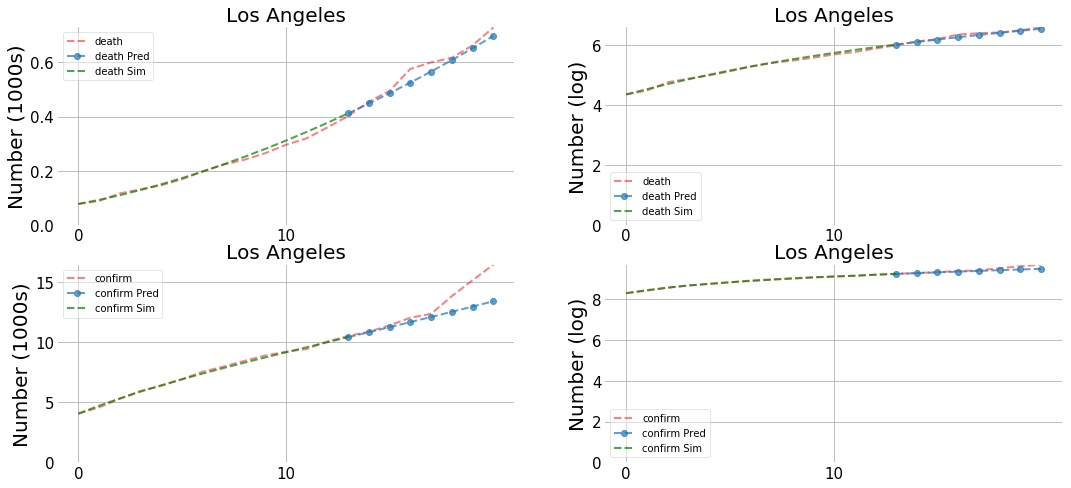

beta: 0.11727272727272726, gamma: 0.13727272727272727, a: 0.1, mu: 0.3111111111111111, case_weight: 1
R length is 21


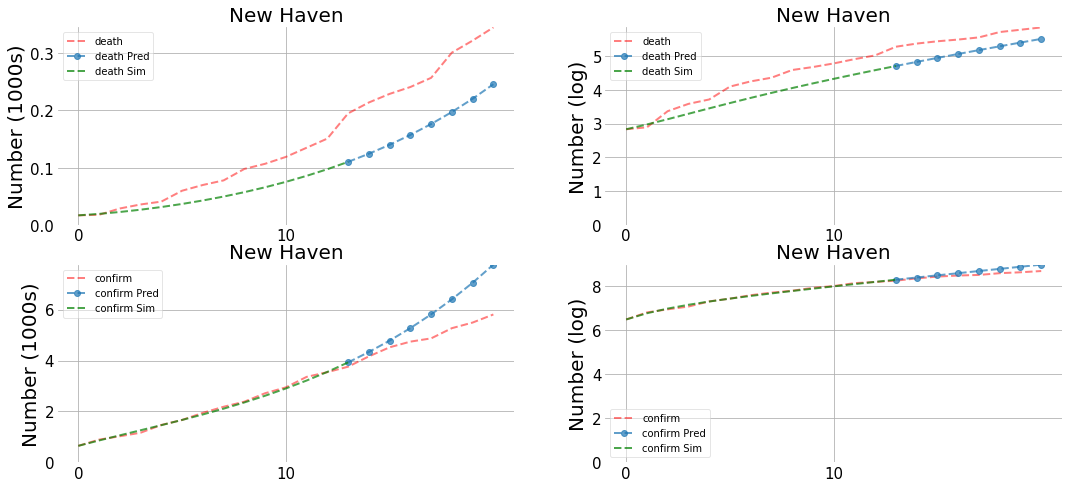

beta: 0.22454545454545455, gamma: 0.13727272727272727, a: 0.2272727272727273, mu: 0.4777777777777778, case_weight: 1
R length is 21


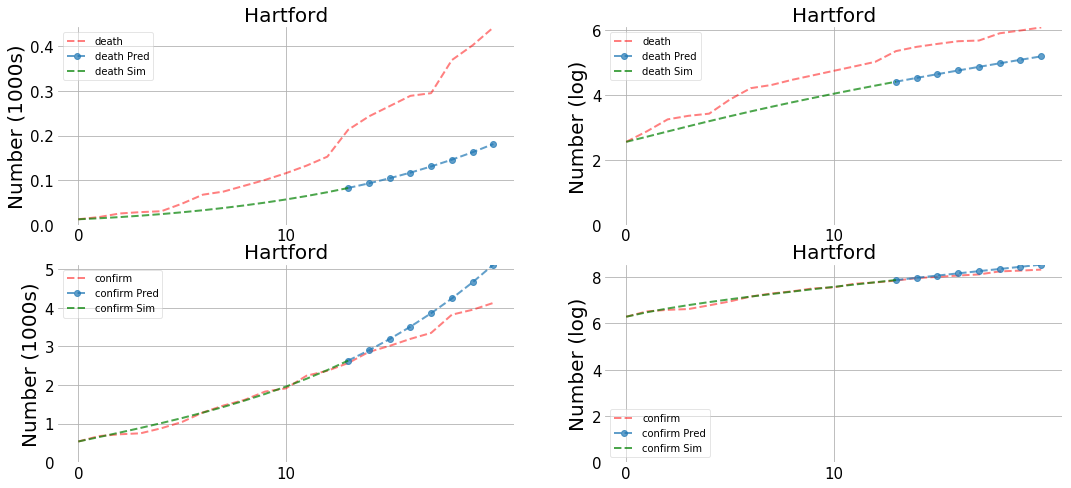

beta: 0.1709090909090909, gamma: 0.15, a: 0.1, mu: 0.3666666666666667, case_weight: 1


In [14]:
# Pop = [4.6e7, 8.1e7, 6.7e7, 6.6e7, 1.7e7, 6e7]
# Region = [ 'Spain', 'Iran', 'France', 'United Kingdom', 'Netherlands', 'Italy']
# Pop = [3.9e7, 8.6e6]
# Region =  ['New York']

Pop = [3e6,1.3e5,1.2e5,5e6]

Region = [ 'California',  'Connecticut', 'Connecticut']
Province = ['Los Angeles',  'New Haven', 'Hartford']
# Region = ['California']
# Province = ['Los Angeles']

# Pop = [5.2e6]
# Region = ['Illinois']
# Province = ['Cook']


# Pop = [1e6]
# Region = ['New Jersey']
# Province = ['Bergen']

Lfuncs = ['weight','MLE']


criter = 'cases'
# measure = 'test'
country = 'US'

usCounties = pd.read_csv('./benchmark/us-counties.csv')

metric = pd.DataFrame()
method=[]
train_size=[]
test_size=[]
regions = []
rel_err = []
abs_err = []



n_tests = [7,14]
n_trains = [7,14]
Loss = ['mse']
Criter = ['infe']
pop,county,state = Pop[0],County[0],State[0]
n_train = 14
n_test=7


# for pop, county, state in zip(Pop, County, State):
#     for loss, criter in zip(Loss, Criter):
for loss in Loss:
    for criter in Criter:
        for region, province in zip(Region, Province):
            countydata = usCounties[(usCounties.county==province)&(usCounties.state==region)].sort_values(by='date')                   
            I = countydata.cases.values
            D = countydata.deaths.values
            method.append(f'SEIR_Gu_{loss}')
            regions.append(county)

#                     loc_cases=cases[(title.state==region)&(title.city==province)].fillna(0).iloc[:,:].values.flatten()
#                     loc_death=death[(title.state==region)&(title.city==province)].fillna(0).iloc[:,:].values.flatten()
#                     print('Region: {}, Loss {}, Criterion {}, n_test {}'.format(region, loss, criter, round(n_test, 2)))
            i_train,i_test,I= run((I,D), loss, criter, region, pop, n_train = n_train, n_test=n_test, province = province)
            rel_err.append(abs(i_test[-1]-I[-1])/I[-1])
            abs_err.append(abs(i_test[-1]-I[-1]))


# metric.to_csv('SEIR_metric.csv')
                